# Barclays Fantasy Football Project

### Approach

The general approach to predicting my set of 15 players for the next gameweek is as follows:

1.	Subset the dataset into different types of players, ie. Goalkeepers, Defenders, Midfielders and Forwards.
2.	Select a set of features based on each player type. This is because GKs score points for saves and clean sheets, while FWs do not, etc. 
3.	Model the data and narrow down to the best candidate model based on several model selection criteria.
4.	Adjust model parameters like lag length until best candidate model is reached. 
5.	Predict the 5 best scoring Goalkeepers, as well as 10 Defenders, Midfielders and Forwards based on the model specified.
6.	Pick 15 players (2 GKs, 5 DFs, 5 MFs and 3 FWs) from 35 subject to the budget cap of £100m. 


In [14]:
## These are the required features and attributes I'll be using
required_fields=['id','first_name','second_name','team_name','team_id','type_name','now_cost','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form']
full_fields = ['id','first_name','second_name','team_name','team_id','type_name','now_cost','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form',
               'bonus_form_t1','fantasy_form_t1','cost_t1','minutes_t1','goals_t1','assists_t1','clean_sheets_t1','goals_conceded_t1','saves_t1','bonus_per_min_t1', 
               'pts_per_min_t1','goals_per_min_t1', 'assists_per_min_t1', 'clean_sheets_per_min_t1','goals_conceded_per_min_t1','saves_per_min_t1','own_team_form',
               'own_team_pos_t','home','next_team','next_team_pos_t','fantasy_points_t']

11
33


In [126]:
import re 
import requests as rq
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import json
import statsmodels.api as st 
from sklearn.linear_model import LinearRegression as linreg

In [11]:
## Pulls data from the BPL Fantasy Leagueapi ##

d = []
for i in range(1,551):
    r = rq.get('http://fantasy.premierleague.com/web/api/elements/%d' %(i)) 
    R = r.json()
    d.append(R)
with open('data.json', 'w') as fp:
    json.dump(d, fp)

In [215]:
##I've stored the data as json beforehand

with open("data.json") as json_file:
    json_data = json.load(json_file)
    

In [4]:
## This bit extracts the league positions for each team from GW26 to GW1 ##
team_codes = [json_data[i]['team_code'] for i in range(len(json_data))] 
TeamPositions= {}
TeamIndex=[1,3,4,6,7,8,11,13,14,20,21,31,35,43,45,56,57,80,91,110]
for i in TeamIndex:
    d=rq.get('http://www.premierleague.com/ajax/league-table/date-timeline/expanded/2015-2016/28-02-2016/%d/CLUB.json' %(i))
    D=d.json()
    TeamPos = [d['Pos'] for d in D['clubDetails']['performance']]
    TeamName = D['clubDetails']['playersToWatch']['byRatingType']['EA_SPORTS_PLAYER_PERFORMANCE_INDEX'][0]['club']['clubCode']
    TeamPositions[TeamName]=TeamPos
    


In [8]:
## Just some cleaning to sort out the ordering 

teamids=(np.unique([json_data[i]['team_name'] for i in range(len(json_data))])).tolist()
teamids[12:17] = [u'Southampton',u'Sunderland',u'Stoke',u'Swansea',u'Spurs']


In [9]:
## I need this dict to give the short form team names in my dataframe later##

tkeys = sorted(TeamPositions.keys())
team_map={teamids[i]:tkeys[i] for i in range(len(tkeys))}

team_map['Stoke']=u'STK'
team_map['Sunderland']=u'SUN'


In [10]:
## This function will give extract features for a given gameweek and a certain lag ## 

def generate_gw_data(gw,lag,json_data):
    data=[]
    t_form=[]
    for i in range(0,549):
        p_data = [json_data[i][required_fields[j]] for j in range(len(required_fields))] 
        ## These "required fields" are the player id, name, team name etc. ##
        p_hist = json_data[i]['fixture_history']['all'] 
        ## This contains the fixture history of the i-th player amongst 550 players.##
        
        ## Form variables are the sum of points from gw-1th to the (gw-1-lag)th gameweek. These are individual performance attributes## 
        
        bonus_form_t1 = float(sum([p_hist[j][16] for j in range((gw-1-lag),(gw-1))]))
        fantasy_form_t1 = float(sum([p_hist[j][19] for j in range((gw-1-lag),(gw-1))]))  
        minutes_t1 = float(sum([p_hist[j][3] for j in range((gw-1-lag),(gw-1))]))
        goals_t1 = float(sum([p_hist[j][4] for j in range((gw-1-lag),(gw-1))]))
        assists_t1 = float(sum([p_hist[j][5] for j in range((gw-1-lag),(gw-1))]))
        clean_sheets_t1 = float(sum([p_hist[j][6] for j in range((gw-1-lag),(gw-1))]))
        goals_conceded_t1 = float(sum([p_hist[j][7] for j in range((gw-1-lag),(gw-1))]))
        saves_t1= float(sum([p_hist[j][13] for j in range((gw-1-lag),(gw-1))]))
        cost_t1 = p_hist[gw-1][18]

        ## Per minute features##
        
        if minutes_t1>0:
            bonus_per_min_t1 = bonus_form_t1/minutes_t1
            pts_per_min_t1 = fantasy_form_t1/minutes_t1
            goals_per_min_t1 = goals_t1/minutes_t1
            assists_per_min_t1 = assists_t1/minutes_t1
            clean_sheets_per_min_t1 = clean_sheets_t1/minutes_t1
            goals_conceded_per_min_t1 = goals_conceded_per_min_t1/minutes_t1
            saves_per_min_t1=saves_t1/minutes_t1
        else:
            bonus_per_min_t1 = pts_per_min_t1 = 
            goals_per_min_t1 = assists_per_min_t1 = 
            clean_sheets_per_min_t1 = goals_conceded_per_min_t1 = saves_per_min_t1= 0
        
        ## Team Performance Attributes ##
        for j in range((gw-1-lag),(gw-1)):
            g= re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[j][2])
            if g.groups()[2]==g.groups()[3]:
                result=1
            elif g.groups()[2]>g.groups()[3]:
                result = 3
            elif g.group()[2]<g.groups()[3]:
                result =0
        t_form.append(result)
        own_team_form=sum(t_form) # use regex to derive the "team form" feature#
        own_team_pos_t= TeamPositions[team_map[json_data[i]['team_name']]][gw]
        next_team=json_data[i]['fixture_history']['all'][gw][2].split()[0][0:3]
        next_team_pos_t= TeamPositions[next_team][gw]
        t_form=[]
        home = re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[gw][2]).groups()[1] == '(H)'
                
        ## Outcome variable ## 
        
        fantasy_points_t=json_data[i]['fixture_history']['all'][gw][19] 
        
        ## Putting them all together ##
        
        p_data.extend([bonus_form_t1,fantasy_form_t1,
                       cost_t1,minutes_t1,goals_t1,assists_t1,
                       clean_sheets_t1,goals_conceded_t1,saves_t1,bonus_per_min_t1, pts_per_min_t1,
                       goals_per_min_t1, assists_per_min_t1, clean_sheets_per_min_t1,goals_conceded_per_min_t1,
                       saves_per_min_t1,own_team_form,own_team_pos_t,home,next_team,next_team_pos_t,fantasy_points_t])
        data.append(p_data)
        
    df = pd.DataFrame(data=data,columns=full_fields) # convert to pandas dataframe
    return df


In [218]:
## Generate some sample data 

GW6= generate_gw_data(6,5,json_data)
GW7= generate_gw_data(7,5,json_data)

GW7.head()

,id,first_name,second_name,team_name,team_id,type_name,now_cost,chance_of_playing_next_round,chance_of_playing_this_round,minutes,...,assists_per_min_t1,clean_sheets_per_min_t1,goals_conceded_per_min_t1,saves_per_min_t1,own_team_form,own_team_pos_t,home,next_team,next_team_pos_t,fantasy_points_t
0,1,Wojciech,Szczesny,Arsenal,1,Goalkeeper,50,0,0,0,...,0,0.000000,0,0.000000,3,2,True,MUN,3,0
1,2,David,Ospina,Arsenal,1,Goalkeeper,47,100,100,90,...,0,0.000000,0,0.000000,3,2,True,MUN,3,0
2,3,Petr,Cech,Arsenal,1,Goalkeeper,60,0,0,2520,...,0,0.006667,0,0.044444,3,2,True,MUN,3,7
3,4,Laurent,Koscielny,Arsenal,1,Defender,63,0,0,2035,...,0,0.005556,0,0.000000,3,2,True,MUN,3,0
4,5,Per,Mertesacker,Arsenal,1,Defender,52,100,100,1817,...,0,0.000000,0,0.000000,3,2,True,MUN,3,6


In [324]:
type_name=["Goalkeeper","Defender","Midfielder","Forward"]

### These are features/attributes that are relevant to the position that they're playing ##  
fwd_attributes=['bonus_form_t1','fantasy_form_t1','minutes_t1','goals_t1','assists_t1','bonus_per_min_t1','pts_per_min_t1','goals_per_min_t1','assists_per_min_t1','own_team_form', 'own_team_pos_t','home', 'next_team_pos_t']
mf_attributes=fwd_attributes + ['clean_sheets_t1','clean_sheets_per_min_t1']
def_attributes = mf_attributes + ['goals_conceded_t1','goals_conceded_per_min_t1']
gk_attributes= def_attributes + ['saves_t1','saves_per_min_t1']
attributes = [gk_attributes,def_attributes,mf_attributes,fwd_attributes]
personal_attributes = ['id','first_name','second_name','team_name','team_id','type_name','cost_t1']
attrkeys = dict(zip(type_name,attributes))

In [327]:
## This function returns a dataframe of 35 players with the highest predicted scores. 5 GKs, 10 DFs, MFs and FWs. ##
def gen_top_35_players(gw,lag,json_data,max_depths,ntrees=20):

    gw_t=generate_gw_data(gw,lag,json_data)
    gw_t1=generate_gw_data(gw+1,lag,json_data)

    ## Remove inactive players ## 

    GW_t=gw_t[gw_t.minutes!=0]
    GW_t1=gw_t1[gw_t1.minutes!=0]
    top35=pd.DataFrame()
    for pos in type_name:
        ## Subset the data for each position ## 
        GW_t_sub=GW_t[GW_t.type_name==pos]
        GW_t1_sub=GW_t1[GW_t1.type_name==pos]

        ## Create relevant feature set and response variable for t-th and t+1-th gameweek ## 
        X_t= GW_t_sub[attrkeys[pos]]
        y_t1= GW_t_sub.fantasy_points_t
        X_t1= GW_t1_sub[attrkeys[pos]]
        y_t2=GW_t1_sub.fantasy_points_t

        ## Fit the Random Forest Regressor ## 

        rfr= RandomForestRegressor(n_estimators=ntrees,random_state=1,max_depth=max_depths[pos])
        rfr_gw=rfr.fit(X_t,y_t1)
        y_t2_hat =rfr_gw.predict(X_t1)
        pred_errors = y_t2_hat-y_t2
        if pos != "Goalkeeper":
            top35= top35.append(
                GW_t_sub[personal_attributes].join((pd.DataFrame({'predictions':y_t2_hat,'actual':y_t2, 'errors':pred_errors},index=GW_t_sub[personal_attributes].index)),how='right').sort_values(by="predictions",ascending=False).head(10))
        else:
            top35= top35.append(GW_t_sub[personal_attributes].join((pd.DataFrame({'predictions':y_t2_hat,'actual':y_t2, 'errors':pred_errors},index=GW_t_sub[personal_attributes].index)),how='right').sort_values(by="predictions",ascending=False).head(5))
        
    return top35
    ## 
        


In [299]:
## This function returns a dataframe of 35 players with the highest predicted scores. 5 GKs, 10 DFs, MFs and FWs. ##
def prediction_scores(gw,lag,json_data,pos,max_depth,max_features,ntrees=20):

    gw_t=generate_gw_data(gw,lag,json_data)
    gw_t1=generate_gw_data(gw+1,lag,json_data)
    
    ## Remove inactive players ## 

    GW_t=gw_t[gw_t.minutes!=0]
    GW_t1=gw_t1[gw_t1.minutes!=0]
    
    
    ## Subset the data for each position ## 
    GW_t_sub=GW_t[GW_t.type_name==pos]
    GW_t1_sub=GW_t1[GW_t1.type_name==pos]

    ## Create relevant feature set and response variable for t-th and t+1-th gameweek ## 
    X_t= GW_t_sub[attrkeys[pos]]
    y_t1= GW_t_sub.fantasy_points_t
    X_t1= GW_t1_sub[attrkeys[pos]]
    y_t2= GW_t1_sub.fantasy_points_t
        
            
    rfr= RandomForestRegressor(n_estimators=ntrees,random_state=1,max_depth=max_depth,max_features=max_features)
    rfr_gw=rfr.fit(X_t,y_t1)
    y_t2_hat =rfr_gw.predict(X_t1)
    pred_errors = y_t2_hat-y_t2
    sq_errors = pred_errors**2
    
    return sum(sq_errors/len(X_t1))
        

8

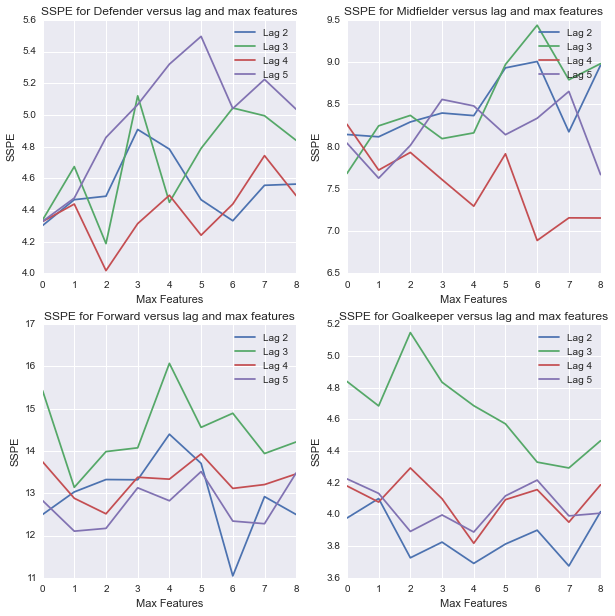

In [315]:
### plotting time 
ind =0 
labels = ["Lag %s" %lag for lag in range(2,6)]
sse_dict2={}
plt.subplots(nrows=2,ncols=2,figsize=(10,10))
for pos in type_name:
    sse_all= []
    for lag in range(2,6):
        sse_lag= []
        for max_features in range(1,10):
            sse_lag.append(prediction_scores(gw,lag,json_data,pos,depth_dict[pos],max_features,ntrees=20))
        sse_all.append(sse_lag)
    sse_dict2[pos]=sse_all
    plt.subplot(2,2,ind)
    for i in range(4):
        plt.plot(sse_all[i])
    plt.title("SSPE for %s versus lag and max features" %pos)
    plt.xlabel("Max Features")
    plt.ylabel("SSPE")
    plt.legend(labels)
    ind += 1

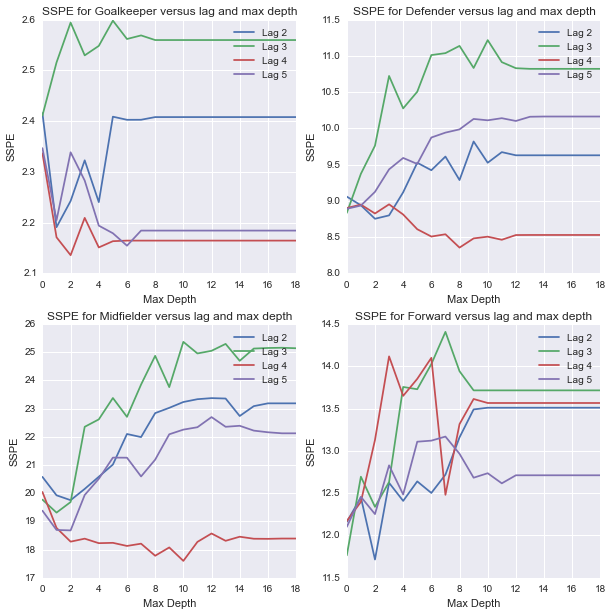

In [307]:
depths=[4,8,10,7]
depth_dict= {type_name[i] : depths[i] for i in range(4)}

## I chose 4, 8, 10 and 7 for max_depth for the various positions 

In [345]:
for gw in range(6,25):

    gw_preds=gen_top_35_players(gw,lag=4,json_data=json_data,max_depths=depth_dict)
    gw_preds.to_csv('Gameweek %d Predictions.csv' %(gw+2),encoding='utf')
    
##I generated new dataframes to import to the R environment where I'll perform the optimisation step

In [346]:
gw_preds

,id,first_name,second_name,team_name,team_id,type_name,cost_t1,actual,errors,predictions
204,205,Joe,Hart,Man City,9,Goalkeeper,55,1,4.334091,5.334091
297,298,Fraser,Forster,Southampton,13,Goalkeeper,48,6,-0.756944,5.243056
225,226,David,de Gea,Man Utd,10,Goalkeeper,56,0,4.748065,4.748065
322,323,Hugo,Lloris,Spurs,14,Goalkeeper,52,3,1.598377,4.598377
487,488,Mark,Bunn,Aston Villa,2,Goalkeeper,43,0,4.404329,4.404329
448,449,Joleon,Lescott,Aston Villa,2,Defender,46,-1,13.400000,12.400000
161,162,Robert,Huth,Leicester,7,Defender,43,1,9.900000,10.900000
301,302,Jose,Fonte,Southampton,13,Defender,53,7,0.650000,7.650000
300,301,Ryan,Bertrand,Southampton,13,Defender,53,6,1.100000,7.100000
333,334,Kieran,Trippier,Spurs,14,Defender,49,0,6.500000,6.500000
